In [ ]:
from tool.load import *

In [ ]:
file_list = nc_list("/mnt/obsdata/isee_nlfff_v1.2/12673")
file_list

[PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_000000.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_003600.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_004800.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_010000.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_011200.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_012400.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_013600.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_014800.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_020000.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_021200.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_022400.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_023600.nc'),
 PosixPath('/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170904_024800.nc'),
 PosixPath('/mnt/obsdata/

In [ ]:
b = load_b(file_list[0])

In [ ]:
b.shape

(3, 513, 257, 257)

In [ ]:
import torch

In [ ]:
input_data = b[:, :, :, 0]
input_data = input_data[:, :, :, None]
input_data = torch.Tensor(input_data)
output_data = b[:, :, :, :50]
output_data = output_data
output_data = torch.Tensor(output_data)

input_data.shape, output_data.shape

(torch.Size([3, 513, 257, 1]), torch.Size([3, 513, 257, 50]))

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
height = nn.Conv3d(in_channels=3, out_channels=3, kernel_size=(3, 3, 2), stride=1, padding=(1, 1, 25))

In [ ]:
maxpol = nn.MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=(0, 0, 0))

In [ ]:
height(input_data).shape

torch.Size([3, 513, 257, 50])

In [ ]:
conv1 = nn.Conv3d(in_channels=3, out_channels=3, kernel_size=2, stride=1, padding=(0, 0, 1))

In [ ]:
conv1(height(input_data)).shape

torch.Size([3, 512, 256, 51])

In [ ]:
maxpol(conv1(height(input_data))).shape

torch.Size([3, 256, 128, 51])

In [ ]:
convT1 = nn.ConvTranspose3d(in_channels=3, out_channels=3, kernel_size=2, stride=1, padding=(0, 0, 1))

In [ ]:
convT1(conv1(height(input_data))).shape

torch.Size([3, 513, 257, 50])

In [ ]:
remap = nn.Conv3d(in_channels=3, out_channels=4, kernel_size=2, stride=(2, 1, 1), padding=(0, 0, 128))

In [ ]:
remap(input_data).shape

torch.Size([4, 256, 256, 256])

In [ ]:
remapT = nn.ConvTranspose3d(in_channels=3, out_channels=3, kernel_size=(3, 2, 1), stride=(2, 1, 1), padding=(0, 0, 103))

In [ ]:
remapT(remap(input_data)).shape

RuntimeError: Given transposed=1, weight of size [3, 3, 3, 2, 1], expected input[1, 4, 256, 256, 256] to have 3 channels, but got 4 channels instead

In [ ]:
conv1 = nn.Conv3d(in_channels=4, out_channels=8, kernel_size=2, stride=1, padding='same')

In [ ]:
conv1(remap(input_data)).shape

torch.Size([8, 256, 256, 256])

In [ ]:
maxpool1 = nn.MaxPool3d(kernel_size=2)

In [ ]:
maxpool1(conv1(remap(input_data))).shape

torch.Size([8, 128, 128, 128])

In [ ]:
convT1 = nn.ConvTranspose3d(in_channels=8, out_channels=4, kernel_size=2, stride=2, padding=0)

In [ ]:
convT1(maxpool1(conv1(remap(input_data)))).shape

torch.Size([4, 256, 256, 256])

In [ ]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.remap = nn.Conv3d(in_channels=3, out_channels=8, kernel_size=2, stride=(2, 1, 1), padding=(0, 0, 128))
        self.remapT = nn.ConvTranspose3d(in_channels=8, out_channels=3, kernel_size=(3, 2, 1), stride=(2, 1, 1), padding=(0, 0, 103))

        self.encoder = nn.Sequential(                                                              
            nn.Conv3d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding='same'), 
            nn.LeakyReLU(0.1),
            nn.MaxPool3d(kernel_size=2), # (16, 128, 128, 128)
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding='same'),
            nn.LeakyReLU(0.1), 
            nn.MaxPool3d(kernel_size=2), # (32, 64, 64, 64)
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding='same'),
            nn.LeakyReLU(0.1), 
            nn.MaxPool3d(kernel_size=2), # (64, 32, 32, 32)    
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding='same'),
            nn.LeakyReLU(0.1), 
            nn.MaxPool3d(kernel_size=2), # (128, 16, 16, 16)         
            nn.Conv3d(in_channels=128, out_channels=1, kernel_size=2, stride=1, padding=1),
            nn.LeakyReLU(0.1), 
            nn.MaxPool3d(kernel_size=2), # (1, 8, 8, 8)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=1, out_channels=128, kernel_size=2, stride=2, padding=0),     # (128, 16, 16, 16)
            nn.LeakyReLU(0.1),
            nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0),    # (64, 32, 32, 32)
            nn.LeakyReLU(0.1),
            nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0),     # (32, 64, 64, 64)
            nn.LeakyReLU(0.1),
            nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),     # (16, 128, 128, 128)
            nn.LeakyReLU(0.1),
            nn.ConvTranspose3d(in_channels=16, out_channels=8, kernel_size=2, stride=2, padding=0),      # (8, 256, 256, 256)
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        x = self.remap(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.remapT(x)
        return x

In [ ]:
model = net()

In [ ]:
B = model.remapT(model.decoder(model.encoder(model.remap(input_data))))

In [ ]:
from tool.evaluate import *

In [ ]:
B = B.detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
bb = b[..., :50]

In [ ]:
bb.shape

(3, 513, 257, 50)

In [ ]:
bbb = bb.transpose(1, 2, 3, 0)
BB = B.transpose(1, 2, 3, 0)

In [ ]:
bbb.shape

(513, 257, 50, 3)

In [ ]:
BB.shape

(513, 257, 50, 3)

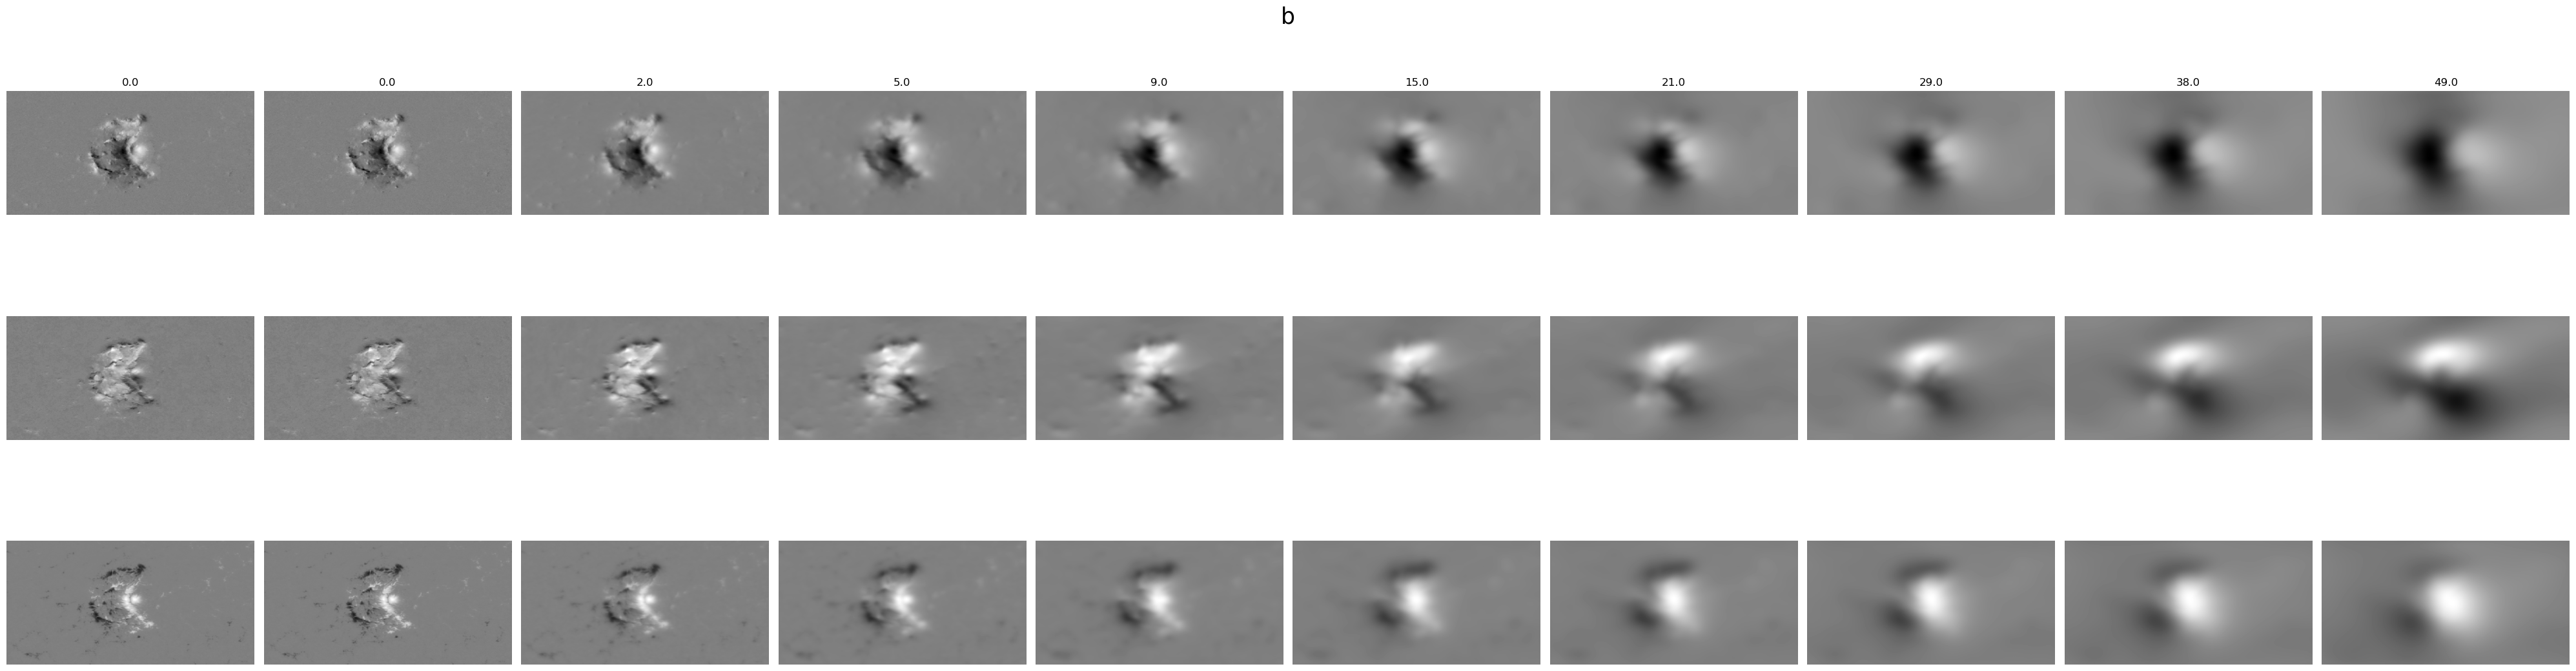

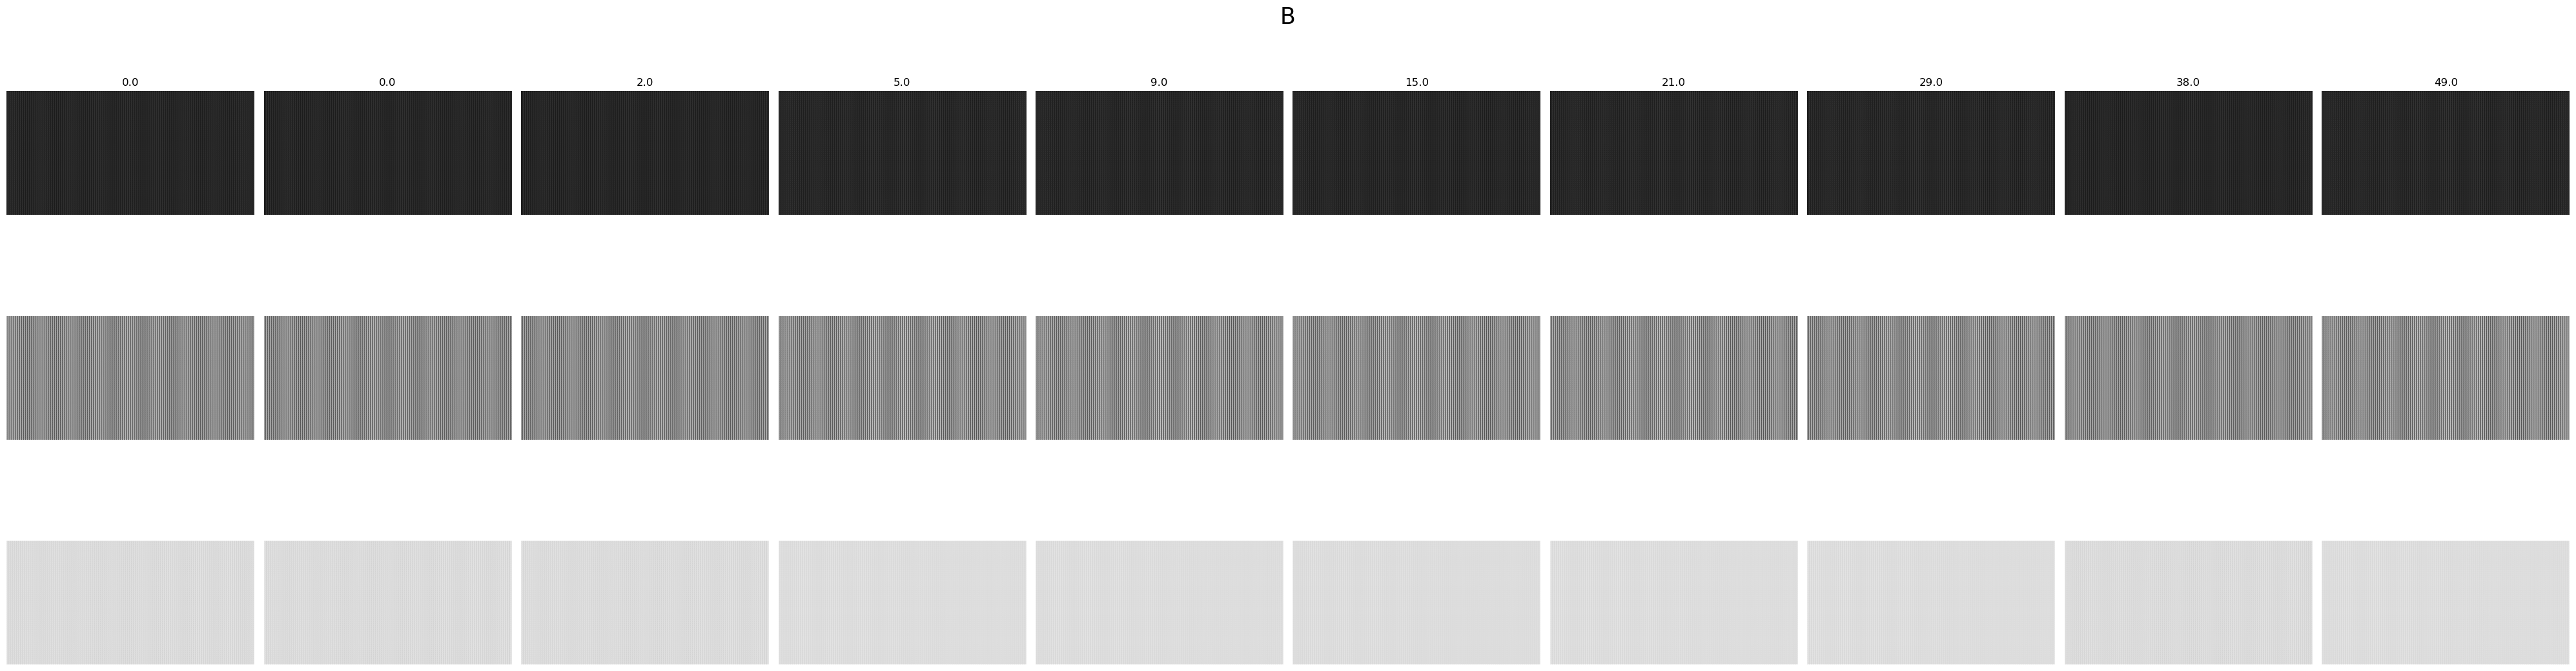

In [ ]:
plot_sample(bbb, BB)

In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [ ]:
model = net().to('cuda')

In [ ]:
y = model(input_data.to('cuda'))

/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv3d(


In [ ]:
y.shape

torch.Size([16, 16, 16, 16])